In [11]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"

import pandas as pd
import numpy as np
import librosa
import IPython.display as ipd
import matplotlib

from typing import Union, Optional
from pathlib import Path

from matplotlib import pyplot as plt
from copy import deepcopy
from scipy.ndimage.measurements import label
from resemblyzer import preprocess_wav, VoiceEncoder, normalize_volume
from resemblyzer.hparams import sampling_rate, audio_norm_target_dBFS
from spectralcluster import SpectralClusterer
from pyannote.core import Annotation, Segment
from pyannote.metrics.diarization import DiarizationErrorRate

from code_base.utils import get_audio_path, milliseconds_2_points, no_trim_preprocess_wav

%matplotlib inline

/tmp/ipykernel_4187787/3923888323.py:15: DeprecationWarning: Please use `label` from the `scipy.ndimage` namespace, the `scipy.ndimage.measurements` namespace is deprecated.
  from scipy.ndimage.measurements import label


In [2]:
!nvidia-smi

Sat Feb 19 14:34:45 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.91.03    Driver Version: 460.91.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  A100-SXM4-40GB      On   | 00000000:0F:00.0 Off |                    0 |
| N/A   41C    P0   213W / 400W |  20686MiB / 40536MiB |     89%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
|   1  A100-SXM4-40GB      On   | 00000000:15:00.0 Off |                    0 |
| N/A   

# Load Data

In [3]:
df = pd.read_csv("../data/processed/markup_filtered.csv")
df

sample_name spk_name  replica_start  replica_end
0         KB0RE000    PS002              0         2464
1         KB0RE000    PS006           2448         2688
2         KB0RE000    PS002           2688         3120
3         KB0RE000    PS006           3120         5056
4         KB0RE000    PS002           4880         5808
...            ...      ...            ...          ...
122888    KE6RE01R    PS0X9         889050       889570
122889    KE6RE01R    PS0X8         889570       904510
122890    KE6RE01R    PS0X9         904510       904600
122891    KE6RE01R    PS0X8         904600       923190
122892    KE6RE01R    PS0X9         923190       923380

[122893 rows x 4 columns]

# Check on one episode

In [4]:
def create_labelling(labels,wav_splits):
    times = [(((s.start + s.stop) / 2) / sampling_rate) * 1000 for s in wav_splits]
    labelling = []
    start_time = 0

    for i,time in enumerate(times):
        if i>0 and labels[i]!=labels[i-1]:
            temp = [str(labels[i-1]),start_time,time]
            labelling.append(tuple(temp))
            start_time = time
        if i==len(times)-1:
            temp = [str(labels[i]),start_time,time]
            labelling.append(tuple(temp))

    return labelling

In [5]:
episode_name = df.sample_name.unique()[11]
episode_df = df[df.sample_name==episode_name].reset_index(drop=True)
print(f"Episode {episode_name} speakers: {episode_df.spk_name.unique()}")
episode_au, episode_sr = librosa.load(get_audio_path("../data/processed/audio/", episode_name), sr=None) 

Episode KB0RE00G speakers: ['PS003' 'PS007']


In [6]:
episode_au = episode_au[:milliseconds_2_points(episode_df.iloc[10].replica_end, episode_sr)]
episode_df = episode_df.iloc[:10]

In [7]:
ipd.Audio(episode_au, rate=episode_sr)

In [9]:
encoder = VoiceEncoder("cuda")

Loaded the voice encoder model on cuda in 3.78 seconds.


In [14]:
episode_au_pp = no_trim_preprocess_wav(fpath_or_wav=episode_au, source_sr=episode_sr)
_, cont_embeds, wav_splits = encoder.embed_utterance(episode_au_pp, return_partials=True, rate=16, )

clusterer = SpectralClusterer(
    min_clusters=episode_df.spk_name.nunique() + 1,
    max_clusters=100
)

labels = clusterer.predict(cont_embeds)
labelling = create_labelling(labels,wav_splits)

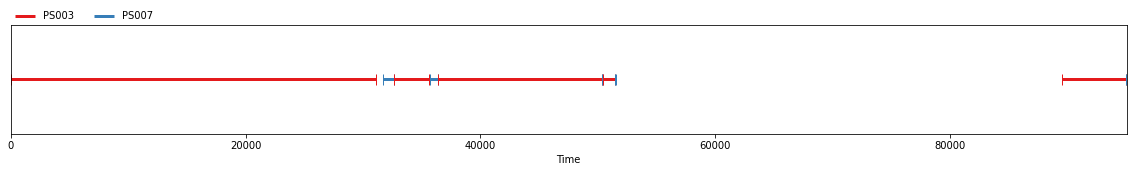

In [15]:
reference = Annotation()
for spk, s,e in zip(episode_df.spk_name, episode_df.replica_start, episode_df.replica_end):
    reference[Segment(s, e)] = spk

reference

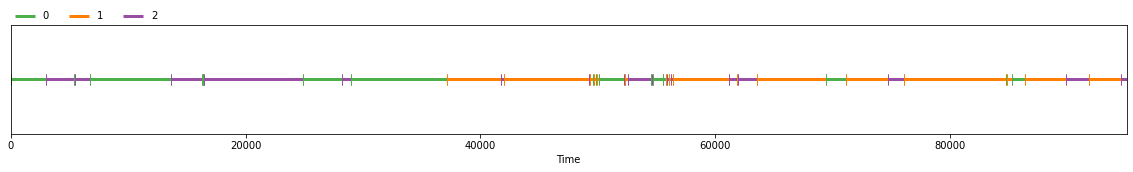

In [16]:
hypothesis = Annotation()
for spk, s,e in labelling:
    hypothesis[Segment(s, e)] = spk

hypothesis

In [17]:
DER = DiarizationErrorRate()
print("IER = {0:.3f}".format(DER(reference, hypothesis)))

IER = 1.435


/home/vova/anaconda3/envs/projector_dsp_workshop/lib/python3.8/site-packages/pyannote/metrics/utils.py:183: UserWarning: 'uem' was approximated by the union of 'reference' and 'hypothesis' extents.
  warnings.warn(


In [ ]:
reference.support()